# **ETA Prediction with Machine Learning**

## **Introduction**

Ride-hailing apps like Uber and Yassir rely on real-time data and machine learning algorithms to automate their services. Accurately predicting the estimated time of arrival (ETA) for Yassir trips will make Yassir’s services more reliable and attractive; this will have a direct and indirect impact on both customers and business partners. The solution would help the company save money and allocate more resources to other parts of the business.

The objective of this hackathon is to predict the estimated time of arrival at the dropoff point for a single Yassir journey.

This project will use the [CRISP-DM](https://www.datascience-pm.com/crisp-dm-2/) framework for data science problems

(Dataset : [Yassir Data](https://zindi.africa/competitions/yassir-eta-prediction-challenge-for-azubian/data))

## **1. Business Understanding**

*Predicting Estimated Time of Arrival (ETA) for Yassir Journeys*

Ride-hailing platforms such as Uber and Yassir operate in a fast-paced environment, relying on real-time data and advanced machine learning algorithms to enhance their services. In particular, accurate prediction of the Estimated Time of Arrival (ETA) for Yassir trips is crucial for improving the reliability and attractiveness of the service to both customers and business partners.

ETAs are used to calculate ride fares, estimate pickup times, match riders to drivers, plan deliveries, and much more. The estimated time of arrival should be as accurate as possible. If estimate is higher then user might cancel the order or if it is lower user might complain and uninstall the app. In both cases there is loss for the company, thus making this a key metric for their business model.

For several years, [Uber used gradient-boosted decision tree ensembles](https://www.uber.com/en-KE/blog/deepeta-how-uber-predicts-arrival-times/) to refine their ETA predictions. As their training dataset grew, Uber’s Apache Spark™ team contributed upstream improvements to XGBoost to allow the model to grow ever deeper, making it one of the largest and deepest XGBoost ensembles in the world at that time. They have since moved to a deep learning due to the ease of scaling on large datasets.

The ETA will vary due to factors such as trip distance and/or weather-related issues.

### Objectives
The  goal is to develop a predictive model capable of accurately estimating the time it takes for a Yassir journey to reach its drop-off point. By achieving this objective, Yassir aims to enhance the overall efficiency and quality of its service, providing tangible benefits to both customers and business partners.

## **2. Data Understanding**

##### **ID:** A unique identifier associated with each record in the dataset.

##### **Timestamp:** The date and time when the trip was started.

##### **Origin_lat and Origin_lon:** The geographical coordinates (latitude and longitude) of the starting point of each trip.

##### **Destination_lat and Destination_lon:** The geographical coordinates (latitude and longitude) of the destination point of each trip.

##### **Trip_distance:** The distance of the trip in in meters on a driving route.

##### **ETA (Estimated Time of Arrival):** Estimated trip time in seconds.

| ID | Timestamp | Origin_lat | Origin_lon | Destination_lat | Destination_lon | Trip_distance | ETA |
|----|-----------|------------|------------|------------------|------------------|---------------|-----|
|Unique| Date| latitude | longitude | destinatination lat | destination long | Trip distance | ETA |

### Importation
Here is the section to import all the packages/libraries that will be used through this notebook.

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#EDA
import geopandas as gpd
from shapely.geometry import Point

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.model_selection import cross_val_score


### Data Loading
Here is the section to load the datasets (train, eval, test) and the additional files

In [2]:
# load training data
training = pd.read_csv(r'Dataset\Train.csv').set_index('ID')
training['Timestamp'] = pd.to_datetime(training['Timestamp'])
training.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
ID,,,,,,,
000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784
000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576
001QSGIH,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526
002ACV6R,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350,3130
0039Y7A8,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613,2138


In [3]:
# testing data
testing = pd.read_csv(r'Dataset\Test.csv').set_index('ID')
testing['Timestamp'] = pd.to_datetime(testing['Timestamp'])
testing.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance
ID,,,,,,
000V4BQX,2019-12-21 05:52:37+00:00,2.981,36.688,2.978,36.754,17549
003WBC5J,2019-12-25 21:38:53+00:00,3.032,36.769,3.074,36.751,7532
004O4X3A,2019-12-29 21:30:29+00:00,3.035,36.711,3.010,36.758,10194
006CEI5B,2019-12-31 22:51:57+00:00,2.902,36.738,3.208,36.698,32768
009G0M2T,2019-12-28 21:47:22+00:00,2.860,36.692,2.828,36.696,4513


In [4]:
# weather data
weather_df = pd.read_csv(r'Dataset\Weather.csv')
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.head()

,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-11-01,290.630524,296.434662,294.125061,101853.617188,292.503998,100806.351562,0.004297,3.561323,0.941695
1,2019-11-02,289.135284,298.432404,295.551666,101225.164062,293.337921,100187.250000,0.001767,5.318593,3.258237
2,2019-11-03,287.667694,296.612122,295.182831,100806.617188,293.674316,99771.414062,0.000797,8.447649,3.172982
3,2019-11-04,287.634644,297.173737,294.368134,101240.929688,292.376221,100200.843750,0.000393,5.991428,2.236700
4,2019-11-05,286.413788,294.284851,292.496979,101131.750000,289.143066,100088.500000,0.004658,6.962730,2.655364


### Exploratory Data Analysis: EDA
Here is the section to **inspect** the datasets in depth, **present** it, make **hypotheses** and **think** the *cleaning, processing and features creation*.

In [20]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83924 entries, 000FLWA8 to ZZZY11ZN
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Timestamp        83924 non-null  datetime64[ns, UTC]
 1   Origin_lat       83924 non-null  float64            
 2   Origin_lon       83924 non-null  float64            
 3   Destination_lat  83924 non-null  float64            
 4   Destination_lon  83924 non-null  float64            
 5   Trip_distance    83924 non-null  int64              
 6   ETA              83924 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(2)
memory usage: 5.1+ MB


In [21]:
training.shape

(83924, 7)

In [22]:
#let's check if we are missing value
training.isna().sum()

Timestamp          0
Origin_lat         0
Origin_lon         0
Destination_lat    0
Destination_lon    0
Trip_distance      0
ETA                0
dtype: int64

- no missing values

In [23]:
# format numerical columns to 2 decimal places with comma separator
pd.options.display.float_format = '{:,.2f}'.format

# statistics for numerical columns
training.describe()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
count,"83,924.00","83,924.00","83,924.00","83,924.00","83,924.00","83,924.00"
mean,3.05,36.74,3.06,36.74,"13,527.82","1,111.70"
std,0.10,0.03,0.10,0.03,"9,296.72",563.57
min,2.81,36.59,2.81,36.60,1.00,1.00
25%,2.99,36.72,3.00,36.72,"6,108.00",701.00
50%,3.05,36.74,3.05,36.74,"11,731.50","1,054.00"
75%,3.10,36.76,3.11,36.76,"19,369.00","1,456.00"
max,3.38,36.82,3.38,36.82,"62,028.00","5,238.00"


- **Timestamp**: The data spans various dates in 2019.
- **Origin and Destination Coordinates (Latitude and Longitude)**: The average coordinates are approximately 3.05 latitude and 36.74 longitude for both origin and destination. The minimum and maximum values show a limited range.
- **Trip Distance**: The average trip distance is approximately 13,527.82 M, with a minimum of 1.00 M and a maximum of 62,028.00 M.
- **ETA (Estimated Time of Arrival)**: The average ETA is approximately 1,111.70s, with a minimum of 1.00s and a maximum of 5,238.00s.**

#### Univariate Analysis

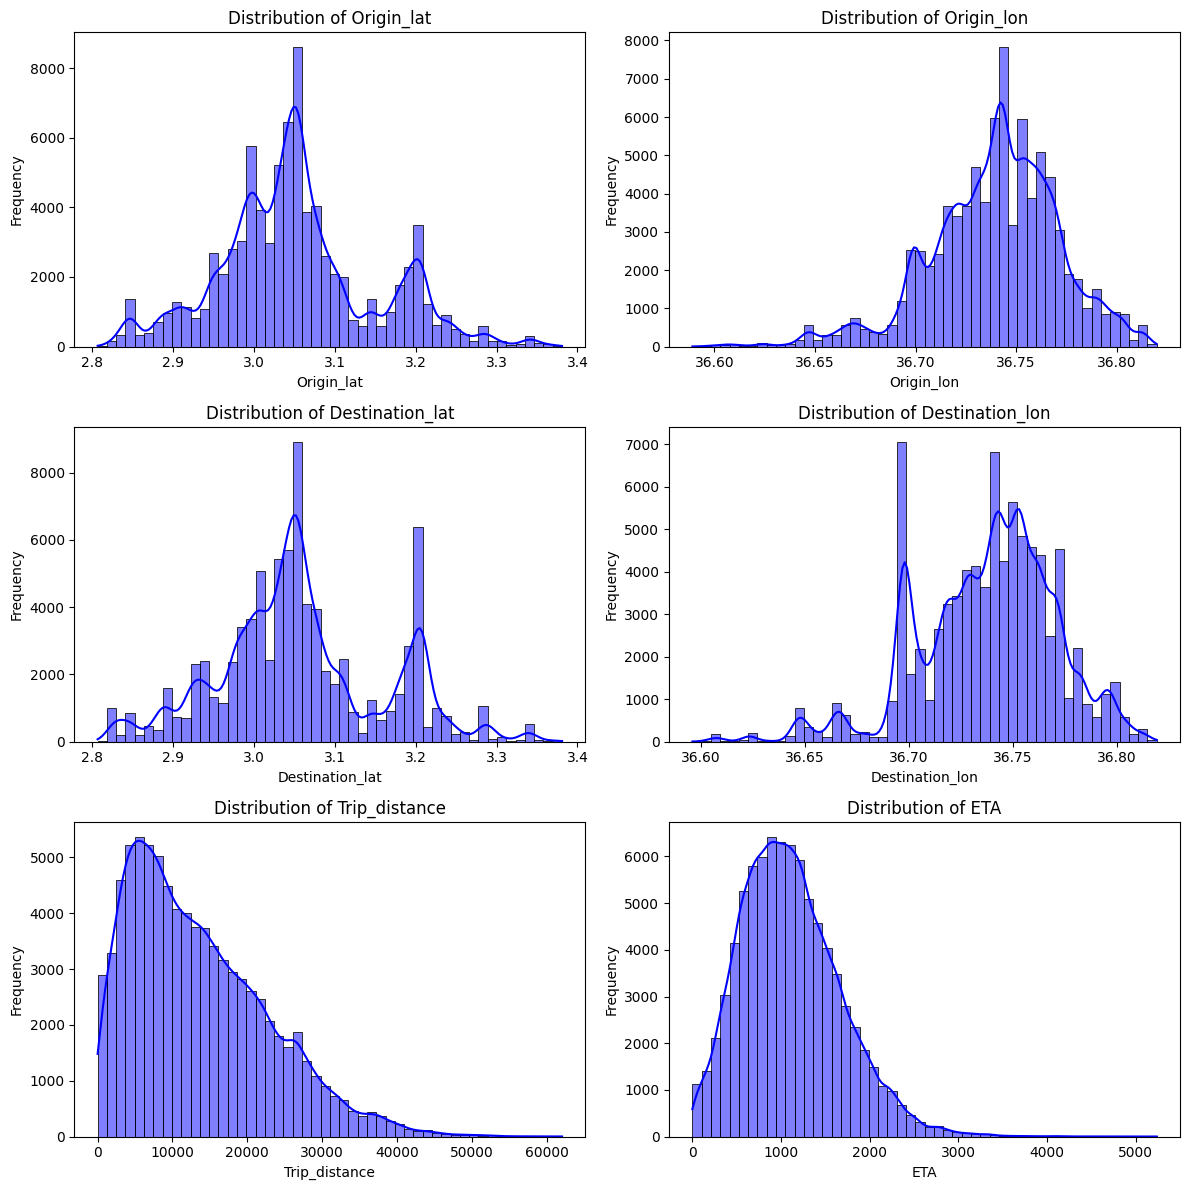

In [24]:
# Create histograms with KDE plots to visualize distribution of other columns

cols = ['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon', 'Trip_distance', 'ETA']

# Calculate the number of rows needed
num_rows = len(cols) // 2 + len(cols) % 2

# Set up subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 4 * num_rows))

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Iterate over columns and create histograms with KDE plots
for i, column in enumerate(cols):
    sns.histplot(training[column], kde=True, bins=50, color='blue', ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove empty subplots if the number of subplots is odd
if len(cols) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

- The origin and destination points seem to be in the same coordinates, indicating that the majority of the trips are likely within a single geographic area. This concentration of data in a specific zone is likely associated with internal activity within a country, potentially representing a dense urban area or a hub of economic activity.

- Trip distance and ETA are positively skewed. This suggest the direction of outliers towards the upper bound of the dataset.

#### Bivariate Analysis

C:\Users\jmutonyi\AppData\Local\Temp\ipykernel_37704\2131882079.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


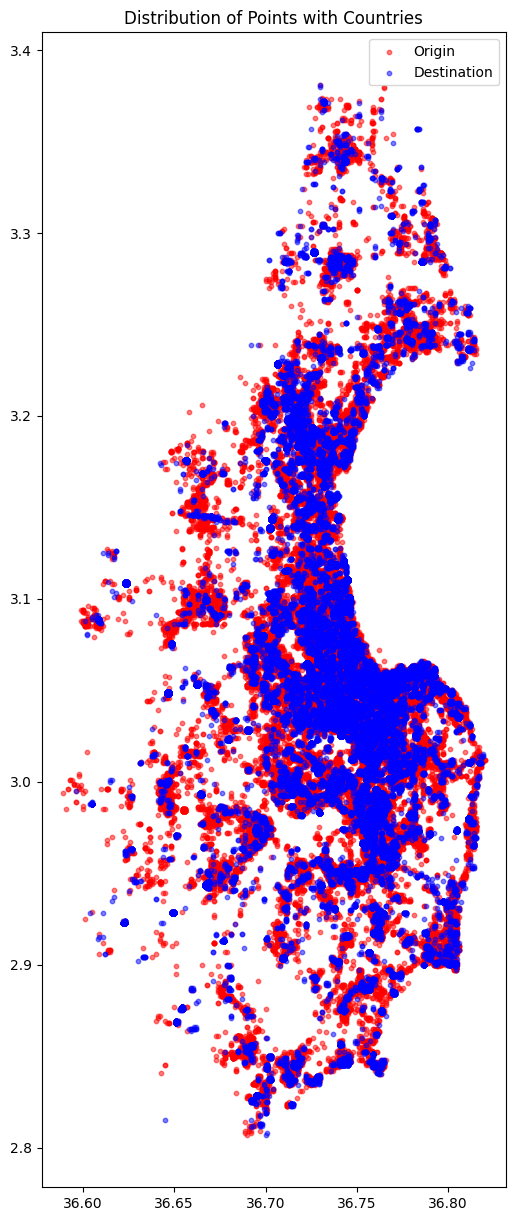

In [29]:
# Create a GeoDataFrame based on the origin coordinates
geometry_origin = [Point(lon, lat) for lon, lat in zip(training['Origin_lon'], training['Origin_lat'])]
gdf_origin = gpd.GeoDataFrame(training, geometry=geometry_origin, crs='EPSG:4326')

# Create a GeoDataFrame based on the destination coordinates
geometry_destination = [Point(lon, lat) for lon, lat in zip(training['Destination_lon'], training['Destination_lat'])]
gdf_destination = gpd.GeoDataFrame(training, geometry=geometry_destination, crs='EPSG:4326')

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Display the world map
fig, ax = plt.subplots(figsize=(15, 15))

# Uncomment the line below if you want to plot world boundaries
# world.boundary.plot(ax=ax, linewidth=1)
ax.set_title('Distribution of Points with Countries')

# Overlay the origin and destination points
gdf_origin.plot(ax=ax, color='red', markersize=10, alpha=0.5, label='Origin')
gdf_destination.plot(ax=ax, color='blue', markersize=10, alpha=0.5, label='Destination')

# Add a legend
plt.legend()

plt.show()

- the visualization of the map indeed confirms the concentration of data within a specific geographic area. The proximity of the origin and destination points, along with the clustering observed on the map, aligns with the interpretation of strong local activity.

In [ ]:
# # First, engineering a lat + long column
# df['GEOM'] = df['Origin_lat'].map(str) + ',' + df['Origin_lon'].map(str)
# df['GEOM'][0:2]

In [ ]:
# from geopy.geocoders import Nominatim

# # Use the geopy locator with Nominatim/OpenStreetMaps
# locator = Nominatim(user_agent='myGeoencoder')
# coordinates = ['3.258,36.777']
# location = locator.reverse(coordinates)
# location.raw

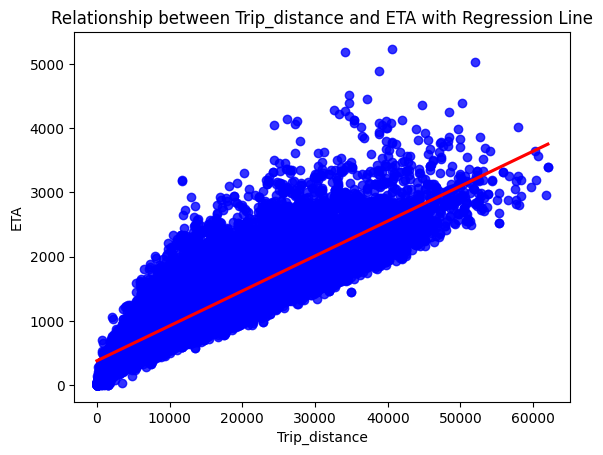

In [30]:
# Scatter plot with regression line
sns.regplot(x='Trip_distance', y='ETA', data=gdf_origin, scatter_kws={'color':'blue'}, line_kws={'color':'red'})

# Set x-axis label
plt.xlabel('Trip_distance')

# Set y-axis label
plt.ylabel('ETA')

# Set plot title
plt.title('Relationship between Trip_distance and ETA with Regression Line')

# Show the plot
plt.show()

The analysis of the relationship between the trip distance ('Trip_distance') and the estimated time of arrival ('ETA') indicates a significant correlation, suggesting a linear trend where longer trip distances are associated with longer arrival times. However, the presence of points deviating from the regression line suggests some variability and the possibility of atypical observations.

#### Multivariate Analysis

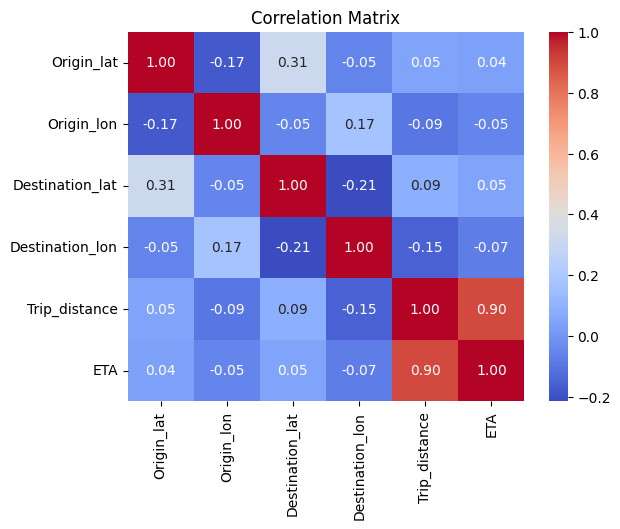

In [31]:
# Create a correlation matrix for continuous variables
train = training.drop('Timestamp', axis=1)
correlation_matrix = train.corr()

# Display the correlation matrix with a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Add a title
plt.title('Correlation Matrix')

# Display the plot
plt.show()

- ETA and trip distance have a strong positive correlation as expected. longer trips typically require more time to be covered.
- There is also a positive relationship between origin/destination latitude and origin/destination longitude

## 3. Data Preparation

### Feature Processing & Engineering
Here is the section to **clean**, **process** the dataset and **create new features**.

In [32]:
training.reset_index(inplace=True)
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83924 entries, 0 to 83923
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   ID               83924 non-null  object             
 1   Timestamp        83924 non-null  datetime64[ns, UTC]
 2   Origin_lat       83924 non-null  float64            
 3   Origin_lon       83924 non-null  float64            
 4   Destination_lat  83924 non-null  float64            
 5   Destination_lon  83924 non-null  float64            
 6   Trip_distance    83924 non-null  int64              
 7   ETA              83924 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(2), object(1)
memory usage: 5.1+ MB


In [33]:
# drop 'ID' column
training.drop(['ID'],axis=1, inplace = True)
training.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
0,2019-12-04 20:01:50+00:00,3.26,36.78,3.00,36.72,39627,2784
1,2019-12-10 22:37:09+00:00,3.09,36.71,3.08,36.73,3918,576
2,2019-11-23 20:36:10+00:00,3.14,36.74,3.09,36.74,7265,526
3,2019-12-01 05:43:21+00:00,3.24,36.78,3.05,36.76,23350,3130
4,2019-12-17 20:30:20+00:00,2.91,36.71,3.21,36.70,36613,2138


#### Add speed feature

In [34]:
# Add 'speed' feature
training['Speed'] = training['Trip_distance'] / training['ETA'] * 3.6
training.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed
0,2019-12-04 20:01:50+00:00,3.26,36.78,3.00,36.72,39627,2784,51.24
1,2019-12-10 22:37:09+00:00,3.09,36.71,3.08,36.73,3918,576,24.49
2,2019-11-23 20:36:10+00:00,3.14,36.74,3.09,36.74,7265,526,49.72
3,2019-12-01 05:43:21+00:00,3.24,36.78,3.05,36.76,23350,3130,26.86
4,2019-12-17 20:30:20+00:00,2.91,36.71,3.21,36.70,36613,2138,61.65


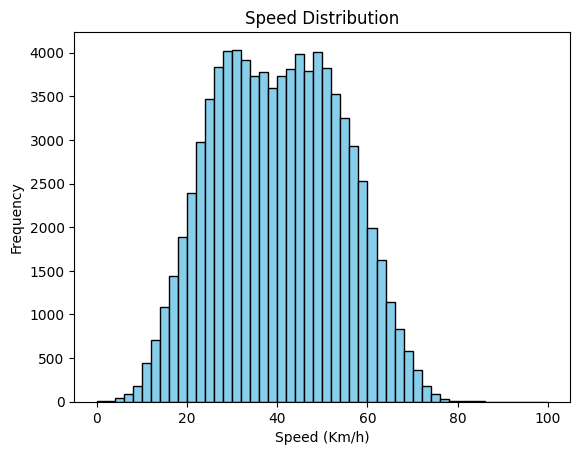

In [35]:
# Histogram of the speed column with x-axis limit
plt.hist(training['Speed'], bins=50, color='skyblue', edgecolor='black', range=[0, 100])
plt.title('Speed Distribution')
plt.xlabel('Speed (Km/h)')
plt.ylabel('Frequency')
plt.show()

We observe a concentration of speed between 0 and 80, indicating that most observations have speeds within this range. This suggests that the majority of trips in our dataset occur at relatively low speeds.

#### Merge training data and weather data

In [36]:
# Merge 'Weather' and 'training' on date column

training['date']=training['Timestamp'].dt.date
training['date']=pd.to_datetime(training['date'])
training_merged=pd.merge(training,weather_df, how='left', on='date')
print(training_merged.shape)
training_merged.head()

(83924, 18)


,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-12-04 20:01:50+00:00,3.26,36.78,3.00,36.72,39627,2784,51.24,2019-12-04,283.05,288.32,286.98,"100,523.06",286.00,"99,474.22",0.01,1.91,2.44
1,2019-12-10 22:37:09+00:00,3.09,36.71,3.08,36.73,3918,576,24.49,2019-12-10,282.29,289.17,286.99,"102,472.15",283.80,"101,401.24",0.00,2.55,-1.54
2,2019-11-23 20:36:10+00:00,3.14,36.74,3.09,36.74,7265,526,49.72,2019-11-23,284.37,292.54,289.94,"100,172.91",287.65,"99,133.38",0.01,6.64,3.55
3,2019-12-01 05:43:21+00:00,3.24,36.78,3.05,36.76,23350,3130,26.86,2019-12-01,284.53,292.35,288.69,"101,382.91",285.94,"100,338.46",0.00,-0.08,1.09
4,2019-12-17 20:30:20+00:00,2.91,36.71,3.21,36.70,36613,2138,61.65,2019-12-17,281.46,292.58,291.20,"100,634.46",287.55,"99,595.82",0.00,-1.77,2.67


#### Extract date-time features

In [37]:
def add_date_features(df,timestamp_id):

    df.loc[:, 'pickup_weekday'] = df[timestamp_id].dt.weekday
    df.loc[:, 'pickup_weekofyear'] = df[timestamp_id].dt.isocalendar().week
    df.loc[:, 'pickup_hour'] = df[timestamp_id].dt.hour
    df.loc[:, 'pickup_minute'] = df[timestamp_id].dt.minute
    df.loc[:, 'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']
  
    df['month']=df[timestamp_id].dt.month
    df['day_name']=df[timestamp_id].dt.day_name()
    df['day_of_week']=df[timestamp_id].dt.dayofweek
    df['day_of_year']=df[timestamp_id].dt.dayofyear


In [38]:
add_date_features(training_merged,'Timestamp')

In [39]:
training_merged.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,date,dewpoint_2m_temperature,...,v_component_of_wind_10m,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_week_hour,month,day_name,day_of_week,day_of_year
0,2019-12-04 20:01:50+00:00,3.26,36.78,3.00,36.72,39627,2784,51.24,2019-12-04,283.05,...,2.44,2,49,20,1,68,12,Wednesday,2,338
1,2019-12-10 22:37:09+00:00,3.09,36.71,3.08,36.73,3918,576,24.49,2019-12-10,282.29,...,-1.54,1,50,22,37,46,12,Tuesday,1,344
2,2019-11-23 20:36:10+00:00,3.14,36.74,3.09,36.74,7265,526,49.72,2019-11-23,284.37,...,3.55,5,47,20,36,140,11,Saturday,5,327
3,2019-12-01 05:43:21+00:00,3.24,36.78,3.05,36.76,23350,3130,26.86,2019-12-01,284.53,...,1.09,6,48,5,43,149,12,Sunday,6,335
4,2019-12-17 20:30:20+00:00,2.91,36.71,3.21,36.70,36613,2138,61.65,2019-12-17,281.46,...,2.67,1,51,20,30,44,12,Tuesday,1,351


#### Handle Outliers

- Outliers have a big effect on rmse score

ETA


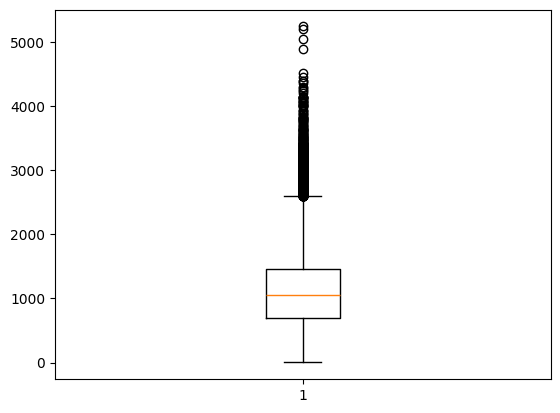

Trip_distance


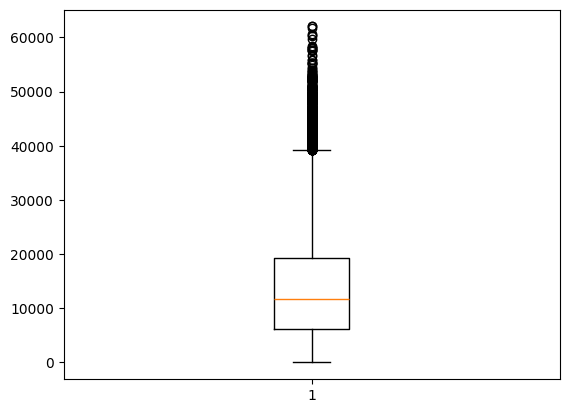

Speed


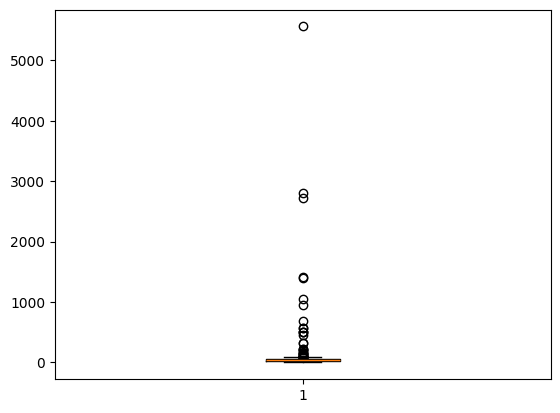

In [41]:
# Check for outliers in the numerical variables
# Use boxplot

for col in ['ETA','Trip_distance','Speed']:
    print(col)
    plt.boxplot(training_merged[col])
    plt.show()

In [42]:
#Function to detect and remove outliers
def remove_outliers(data, columns, threshold=1.5):
    """
    Remove outliers from numerical columns using the Interquartile Range (IQR) method.

    Parameters:
    - data: DataFrame, the input DataFrame.
    - columns: list, the list of numerical columns for which outliers should be removed.
    - threshold: float, the threshold to determine outliers (default is 1.5).

    Returns:
    - DataFrame, the DataFrame without outliers in the specified columns.
    """

    data_no_outliers = training_merged.copy()

    for column in columns:
        # Calculate the IQR for the column
        q1 = data_no_outliers[column].quantile(0.25)
        q3 = data_no_outliers[column].quantile(0.75)
        iqr = q3 - q1

        # Define the lower and upper bounds for outliers
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr

        # Remove outliers
        data_no_outliers = data_no_outliers[(data_no_outliers[column] >= lower_bound) & (data_no_outliers[column] <= upper_bound)]

    return data_no_outliers

In [43]:
numeric_columns = ['ETA', 'Speed', 'Trip_distance']
no_outliers = remove_outliers(training_merged, numeric_columns)
no_outliers = no_outliers.reset_index(drop=True)

In [44]:
no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82213 entries, 0 to 82212
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   Timestamp                   82213 non-null  datetime64[ns, UTC]
 1   Origin_lat                  82213 non-null  float64            
 2   Origin_lon                  82213 non-null  float64            
 3   Destination_lat             82213 non-null  float64            
 4   Destination_lon             82213 non-null  float64            
 5   Trip_distance               82213 non-null  int64              
 6   ETA                         82213 non-null  int64              
 7   Speed                       82213 non-null  float64            
 8   date                        82213 non-null  datetime64[ns]     
 9   dewpoint_2m_temperature     82213 non-null  float64            
 10  maximum_2m_air_temperature  82213 non-null  float64       

#### handle missing values

In [48]:
#check missing values
no_outliers.isna().sum()

Timestamp                     0
Origin_lat                    0
Origin_lon                    0
Destination_lat               0
Destination_lon               0
Trip_distance                 0
ETA                           0
Speed                         0
date                          0
dewpoint_2m_temperature       0
maximum_2m_air_temperature    0
mean_2m_air_temperature       0
mean_sea_level_pressure       0
minimum_2m_air_temperature    0
surface_pressure              0
total_precipitation           0
u_component_of_wind_10m       0
v_component_of_wind_10m       0
pickup_weekday                0
pickup_weekofyear             0
pickup_hour                   0
pickup_minute                 0
pickup_week_hour              0
month                         0
day_name                      0
day_of_week                   0
day_of_year                   0
dtype: int64

#### handle duplicate values

In [49]:
#check for duplicates
no_outliers.duplicated().sum()

157

In [50]:
# show all occurences of duplicated rows
no_outliers[no_outliers.duplicated(keep=False)]

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,date,dewpoint_2m_temperature,...,v_component_of_wind_10m,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_week_hour,month,day_name,day_of_week,day_of_year
41,2019-11-21 00:31:50+00:00,2.92,36.80,3.03,36.77,13707,1306,37.78,2019-11-21,283.45,...,1.86,3,47,0,31,72,11,Thursday,3,325
444,2019-12-03 00:12:03+00:00,3.23,36.72,3.24,36.74,6742,525,46.23,2019-12-03,286.09,...,-0.76,1,49,0,12,24,12,Tuesday,1,337
777,2019-12-05 20:28:47+00:00,2.99,36.76,3.06,36.77,11368,1222,33.49,2019-12-05,283.38,...,0.96,3,49,20,28,92,12,Thursday,3,339
1018,2019-12-17 00:21:30+00:00,3.06,36.79,3.06,36.79,378,176,7.73,2019-12-17,281.46,...,2.67,1,51,0,21,24,12,Tuesday,1,351
1127,2019-12-12 00:10:50+00:00,3.04,36.73,3.06,36.76,10054,735,49.24,2019-12-12,281.36,...,0.57,3,50,0,10,72,12,Thursday,3,346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81271,2019-12-14 04:10:08+00:00,3.07,36.74,3.07,36.75,536,112,17.23,2019-12-14,284.23,...,1.82,5,50,4,10,124,12,Saturday,5,348
81401,2019-11-29 20:04:01+00:00,2.98,36.67,2.99,36.78,25603,1788,51.55,2019-11-29,284.88,...,1.09,4,48,20,4,116,11,Friday,4,333
81695,2019-11-19 23:46:58+00:00,2.85,36.68,3.05,36.78,26065,1678,55.92,2019-11-19,281.22,...,0.88,1,47,23,46,47,11,Tuesday,1,323
81924,2019-11-21 20:33:51+00:00,3.06,36.74,3.05,36.65,13783,1231,40.31,2019-11-21,283.45,...,1.86,3,47,20,33,92,11,Thursday,3,325


In [51]:
# Drop duplicates
no_outliers.drop_duplicates(inplace = True)

In [52]:
no_outliers = no_outliers.reset_index(drop=True)
no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82056 entries, 0 to 82055
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   Timestamp                   82056 non-null  datetime64[ns, UTC]
 1   Origin_lat                  82056 non-null  float64            
 2   Origin_lon                  82056 non-null  float64            
 3   Destination_lat             82056 non-null  float64            
 4   Destination_lon             82056 non-null  float64            
 5   Trip_distance               82056 non-null  int64              
 6   ETA                         82056 non-null  int64              
 7   Speed                       82056 non-null  float64            
 8   date                        82056 non-null  datetime64[ns]     
 9   dewpoint_2m_temperature     82056 non-null  float64            
 10  maximum_2m_air_temperature  82056 non-null  float64       

#### Clustering coordinates

c:\Users\jmutonyi\Desktop\Azubi Data Analytics\Capstone\Estimated-Time-of-Arrival-ETA-Prediction\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jmutonyi\Desktop\Azubi Data Analytics\Capstone\Estimated-Time-of-Arrival-ETA-Prediction\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jmutonyi\Desktop\Azubi Data Analytics\Capstone\Estimated-Time-of-Arrival-ETA-Prediction\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

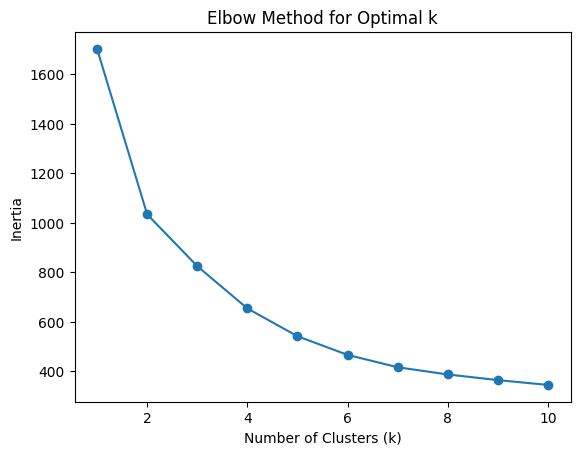

In [54]:
coords = no_outliers[['Origin_lat'	,'Origin_lon'	,'Destination_lat'	,'Destination_lon']]

# Assuming data is your feature matrix
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [56]:
#trip clustering
kmean=KMeans(n_clusters=10,random_state= 0)

no_outliers["cluster_id"]=kmean.fit_predict(coords)

c:\Users\jmutonyi\Desktop\Azubi Data Analytics\Capstone\Estimated-Time-of-Arrival-ETA-Prediction\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [57]:
no_outliers.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,date,dewpoint_2m_temperature,...,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_week_hour,month,day_name,day_of_week,day_of_year,cluster_id
0,2019-12-10 22:37:09+00:00,3.09,36.71,3.08,36.73,3918,576,24.49,2019-12-10,282.29,...,1,50,22,37,46,12,Tuesday,1,344,5
1,2019-11-23 20:36:10+00:00,3.14,36.74,3.09,36.74,7265,526,49.72,2019-11-23,284.37,...,5,47,20,36,140,11,Saturday,5,327,2
2,2019-12-17 20:30:20+00:00,2.91,36.71,3.21,36.70,36613,2138,61.65,2019-12-17,281.46,...,1,51,20,30,44,12,Tuesday,1,351,1
3,2019-12-01 04:21:03+00:00,3.00,36.74,3.21,36.70,25342,1341,68.03,2019-12-01,284.53,...,6,48,4,21,148,12,Sunday,6,335,1
4,2019-12-10 23:08:35+00:00,3.05,36.77,3.06,36.78,2814,606,16.72,2019-12-10,282.29,...,1,50,23,8,47,12,Tuesday,1,344,7


#### Transform target variable

C:\Users\jmutonyi\AppData\Local\Temp\ipykernel_37704\1602136167.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target)


skewness :  0.3409887557960744


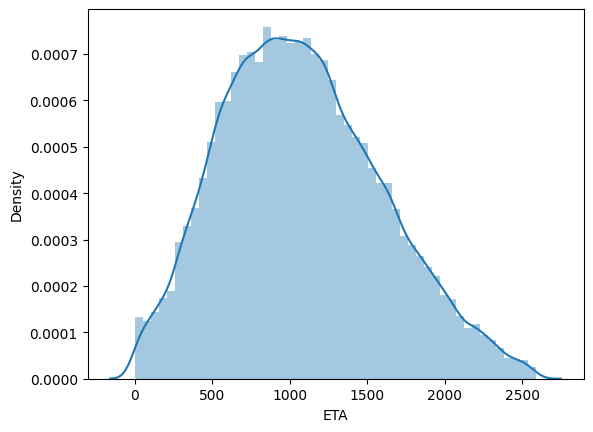

In [58]:
target = no_outliers["ETA"]
sns.distplot(target)
print("skewness : ",stats.skew(target.values))

C:\Users\jmutonyi\AppData\Local\Temp\ipykernel_37704\3011709349.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target_transformed)


Skewness after Box-Cox transformation: [-0.06732219]


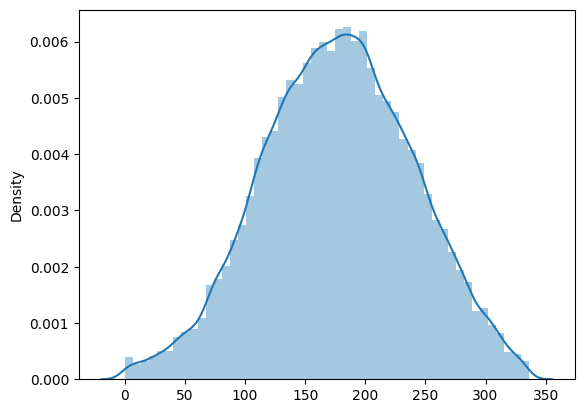

In [59]:
# Reshape the target variable for PowerTransformer
target = target.values.reshape(-1, 1)

# Create and fit the PowerTransformer
boxcox_transformer = PowerTransformer(method='box-cox', standardize=False)
target_transformed = boxcox_transformer.fit_transform(target)

# Plot the distribution of the transformed target variable
sns.distplot(target_transformed)
print("Skewness after Box-Cox transformation:", stats.skew(target_transformed))

In [60]:
no_outliers['target_transformed'] = target_transformed
no_outliers.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,date,dewpoint_2m_temperature,...,pickup_weekofyear,pickup_hour,pickup_minute,pickup_week_hour,month,day_name,day_of_week,day_of_year,cluster_id,target_transformed
0,2019-12-10 22:37:09+00:00,3.09,36.71,3.08,36.73,3918,576,24.49,2019-12-10,282.29,...,50,22,37,46,12,Tuesday,1,344,5,117.41
1,2019-11-23 20:36:10+00:00,3.14,36.74,3.09,36.74,7265,526,49.72,2019-11-23,284.37,...,47,20,36,140,11,Saturday,5,327,2,110.15
2,2019-12-17 20:30:20+00:00,2.91,36.71,3.21,36.70,36613,2138,61.65,2019-12-17,281.46,...,51,20,30,44,12,Tuesday,1,351,1,294.01
3,2019-12-01 04:21:03+00:00,3.00,36.74,3.21,36.70,25342,1341,68.03,2019-12-01,284.53,...,48,4,21,148,12,Sunday,6,335,1,212.27
4,2019-12-10 23:08:35+00:00,3.05,36.77,3.06,36.78,2814,606,16.72,2019-12-10,282.29,...,50,23,8,47,12,Tuesday,1,344,7,121.68


In [61]:
#drop columns
no_outliers = no_outliers.drop(columns= ['date', 'day_name']
              ,axis=1)

In [62]:
no_outliers = no_outliers.set_index('Timestamp')
no_outliers.head()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,...,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_week_hour,month,day_of_week,day_of_year,cluster_id,target_transformed
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-12-10 22:37:09+00:00,3.09,36.71,3.08,36.73,3918,576,24.49,282.29,289.17,286.99,...,1,50,22,37,46,12,1,344,5,117.41
2019-11-23 20:36:10+00:00,3.14,36.74,3.09,36.74,7265,526,49.72,284.37,292.54,289.94,...,5,47,20,36,140,11,5,327,2,110.15
2019-12-17 20:30:20+00:00,2.91,36.71,3.21,36.70,36613,2138,61.65,281.46,292.58,291.20,...,1,51,20,30,44,12,1,351,1,294.01
2019-12-01 04:21:03+00:00,3.00,36.74,3.21,36.70,25342,1341,68.03,284.53,292.35,288.69,...,6,48,4,21,148,12,6,335,1,212.27
2019-12-10 23:08:35+00:00,3.05,36.77,3.06,36.78,2814,606,16.72,282.29,289.17,286.99,...,1,50,23,8,47,12,1,344,7,121.68


In [63]:
no_outliers.sort_index(ascending=True, inplace=True)
no_outliers.tail()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,...,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_week_hour,month,day_of_week,day_of_year,cluster_id,target_transformed
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-12-19 23:58:39+00:00,3.05,36.77,2.98,36.75,11650,1019,41.16,281.00,290.57,286.99,...,3,51,23,58,95,12,3,353,7,175.18
2019-12-19 23:59:01+00:00,3.05,36.77,2.98,36.75,11650,1019,41.16,281.00,290.57,286.99,...,3,51,23,59,95,12,3,353,7,175.18
2019-12-19 23:59:21+00:00,3.06,36.72,3.07,36.75,8191,926,31.84,281.00,290.57,286.99,...,3,51,23,59,95,12,3,353,5,163.82
2019-12-19 23:59:25+00:00,3.03,36.77,3.03,36.76,2617,299,31.51,281.00,290.57,286.99,...,3,51,23,59,95,12,3,353,7,73.95
2019-12-19 23:59:29+00:00,3.21,36.70,3.03,36.76,23495,1322,63.98,281.00,290.57,286.99,...,3,51,23,59,95,12,3,353,2,210.17


In [65]:
no_outliers['pickup_weekofyear'] = no_outliers['pickup_weekofyear'].astype('int32')  # Adjust column_name to your actual column

In [66]:
no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82056 entries, 2019-11-19 23:00:08+00:00 to 2019-12-19 23:59:29+00:00
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Origin_lat                  82056 non-null  float64
 1   Origin_lon                  82056 non-null  float64
 2   Destination_lat             82056 non-null  float64
 3   Destination_lon             82056 non-null  float64
 4   Trip_distance               82056 non-null  int64  
 5   ETA                         82056 non-null  int64  
 6   Speed                       82056 non-null  float64
 7   dewpoint_2m_temperature     82056 non-null  float64
 8   maximum_2m_air_temperature  82056 non-null  float64
 9   mean_2m_air_temperature     82056 non-null  float64
 10  mean_sea_level_pressure     82056 non-null  float64
 11  minimum_2m_air_temperature  82056 non-null  float64
 12  surface_pressure            82056 non-nul

In [67]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

In [68]:
clean_dataset(no_outliers)

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Speed,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,...,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_week_hour,month,day_of_week,day_of_year,cluster_id,target_transformed
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-11-19 23:00:08+00:00,3.02,36.75,3.03,36.77,"3,898.00",556.00,25.24,281.22,288.50,285.20,...,1.00,47.00,23.00,0.00,47.00,11.00,1.00,323.00,7.00,114.53
2019-11-19 23:00:10+00:00,2.97,36.76,3.01,36.73,"5,861.00",785.00,26.88,281.22,288.50,285.20,...,1.00,47.00,23.00,0.00,47.00,11.00,1.00,323.00,6.00,145.91
2019-11-19 23:00:38+00:00,2.85,36.68,3.05,36.78,"26,065.00","1,661.00",56.49,281.22,288.50,285.20,...,1.00,47.00,23.00,0.00,47.00,11.00,1.00,323.00,0.00,246.51
2019-11-19 23:00:44+00:00,2.98,36.76,3.00,36.78,"4,943.00",629.00,28.29,281.22,288.50,285.20,...,1.00,47.00,23.00,0.00,47.00,11.00,1.00,323.00,6.00,124.91
2019-11-19 23:00:53+00:00,2.86,36.76,3.19,36.72,"37,492.00","2,181.00",61.89,281.22,288.50,285.20,...,1.00,47.00,23.00,0.00,47.00,11.00,1.00,323.00,0.00,298.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19 23:58:39+00:00,3.05,36.77,2.98,36.75,"11,650.00","1,019.00",41.16,281.00,290.57,286.99,...,3.00,51.00,23.00,58.00,95.00,12.00,3.00,353.00,7.00,175.18
2019-12-19 23:59:01+00:00,3.05,36.77,2.98,36.75,"11,650.00","1,019.00",41.16,281.00,290.57,286.99,...,3.00,51.00,23.00,59.00,95.00,12.00,3.00,353.00,7.00,175.18
2019-12-19 23:59:21+00:00,3.06,36.72,3.07,36.75,"8,191.00",926.00,31.84,281.00,290.57,286.99,...,3.00,51.00,23.00,59.00,95.00,12.00,3.00,353.00,5.00,163.82


In [69]:
no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82056 entries, 2019-11-19 23:00:08+00:00 to 2019-12-19 23:59:29+00:00
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Origin_lat                  82056 non-null  float64
 1   Origin_lon                  82056 non-null  float64
 2   Destination_lat             82056 non-null  float64
 3   Destination_lon             82056 non-null  float64
 4   Trip_distance               82056 non-null  int64  
 5   ETA                         82056 non-null  int64  
 6   Speed                       82056 non-null  float64
 7   dewpoint_2m_temperature     82056 non-null  float64
 8   maximum_2m_air_temperature  82056 non-null  float64
 9   mean_2m_air_temperature     82056 non-null  float64
 10  mean_sea_level_pressure     82056 non-null  float64
 11  minimum_2m_air_temperature  82056 non-null  float64
 12  surface_pressure            82056 non-nul

#### X and Y split

In [70]:
X =no_outliers.drop('ETA',axis=1)
X.head()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,Speed,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,...,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_week_hour,month,day_of_week,day_of_year,cluster_id,target_transformed
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-11-19 23:00:08+00:00,3.02,36.75,3.03,36.77,3898,25.24,281.22,288.50,285.20,"101,709.28",...,1,47,23,0,47,11,1,323,7,114.53
2019-11-19 23:00:10+00:00,2.97,36.76,3.01,36.73,5861,26.88,281.22,288.50,285.20,"101,709.28",...,1,47,23,0,47,11,1,323,6,145.91
2019-11-19 23:00:38+00:00,2.85,36.68,3.05,36.78,26065,56.49,281.22,288.50,285.20,"101,709.28",...,1,47,23,0,47,11,1,323,0,246.51
2019-11-19 23:00:44+00:00,2.98,36.76,3.00,36.78,4943,28.29,281.22,288.50,285.20,"101,709.28",...,1,47,23,0,47,11,1,323,6,124.91
2019-11-19 23:00:53+00:00,2.86,36.76,3.19,36.72,37492,61.89,281.22,288.50,285.20,"101,709.28",...,1,47,23,0,47,11,1,323,0,298.12


In [71]:
y = no_outliers["ETA"]
y.head()

Timestamp
2019-11-19 23:00:08+00:00     556
2019-11-19 23:00:10+00:00     785
2019-11-19 23:00:38+00:00    1661
2019-11-19 23:00:44+00:00     629
2019-11-19 23:00:53+00:00    2181
Name: ETA, dtype: int64

#### Pipeline

In [72]:
input_features =X.columns
input_features

Index(['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon',
       'Trip_distance', 'Speed', 'dewpoint_2m_temperature',
       'maximum_2m_air_temperature', 'mean_2m_air_temperature',
       'mean_sea_level_pressure', 'minimum_2m_air_temperature',
       'surface_pressure', 'total_precipitation', 'u_component_of_wind_10m',
       'v_component_of_wind_10m', 'pickup_weekday', 'pickup_weekofyear',
       'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'month',
       'day_of_week', 'day_of_year', 'cluster_id', 'target_transformed'],
      dtype='object')

In [86]:
#column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler',StandardScaler(),input_features)
        #('log_transformer',FunctionTransformer(np.log1p),input_features)
    ]
)

#### Train - Test Split

In [74]:
82056 * 0.2

16411.2

In [75]:
X_train = X.iloc[:-17000]
X_test = X.iloc[-17000:]
X_train.shape,X_test.shape

((65056, 25), (17000, 25))

In [76]:
y_train = y.iloc[:-17000]
y_test = y.iloc[-17000:]
y_train.shape,y_test.shape

((65056,), (17000,))

In [78]:
##Linear Regression
lr_model = LinearRegression()
model = lr_model.fit(X_train, y_train)

In [80]:
# get feature importance
importance = lr_model.coef_
# Converting the feature importance data into a dataframe
importance = pd.DataFrame(importance, columns = ["score"]).reset_index()
importance["Feature"] = list(X.columns)
importance.drop(columns = ["index"], inplace = True)
importance.sort_values(by = "score", ascending = False)
importance
# Visualizing the feature importance
fig = px.bar(importance, x = "Feature", y = "score")
fig.show()

In [82]:
prediction = lr_model.predict(X_test)
prediction[:10]

array([1046.75319379, 1187.58338372, 1573.73317588,  931.9287793 ,
       1187.61451296,  715.36759127,  297.75077102, 1369.58636554,
        941.83177746,  715.36759127])

In [83]:
y_test[:10]

Timestamp
2019-12-13 20:30:50+00:00    1046
2019-12-13 20:30:58+00:00    1178
2019-12-13 20:30:58+00:00    1565
2019-12-13 20:31:05+00:00     917
2019-12-13 20:31:12+00:00    1178
2019-12-13 20:31:20+00:00     676
2019-12-13 20:31:22+00:00     329
2019-12-13 20:31:34+00:00    1367
2019-12-13 20:31:35+00:00     930
2019-12-13 20:31:43+00:00     676
Name: ETA, dtype: int64

In [85]:
rmse = mean_squared_error(prediction,y_test, squared=False)
mae = mean_absolute_error(prediction,y_test)
print(rmse,mae)

37.04752559417143 23.84143807506187


In [84]:
# Predicting and Evaluating the Linear Regression model
prediction = lr_model.predict(X_test)
mse = mean_squared_error(y_test, prediction)
lr_rmse = np.sqrt(mse)
print(mse)
print(lr_rmse)

1372.5191526507872
37.04752559417143


## 4. Machine Learning Modeling 
Here is the section to **build**, **train**, **evaluate** and **compare** the models to each others.

#### Linear Regression

In [87]:
# create and fit model
LR = LinearRegression()
pipeline_LR =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('Linear Regression',LR)
])

pipeline_LR.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon',
       'Trip_distance', 'Speed', 'dewpoint_2m_temperature',
       'maximum_2m_air_temperature', 'mean_2m_air_temperature',
       'mean_sea_level_pressure', 'minimum_2m_air_temperature',
       'surface_pressure', 'total_precipitation', 'u_component_of_wind_10m',
       'v_component_of_wind_10m', 'pickup_weekday', 'pickup_weekofyear',
       'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'month',
       'day_of_week', 'day_of_year', 'cluster_id', 'target_transformed'],
      dtype='object'))])),
                ('Linear Regression', LinearRegression())])

In [91]:
predictions = pipeline_LR.predict(X_test)
predictions[:10]

array([1046.75319379, 1187.58338372, 1573.73317588,  931.9287793 ,
       1187.61451296,  715.36759127,  297.75077102, 1369.58636554,
        941.83177746,  715.36759127])

In [92]:
y_test[:10]

Timestamp
2019-12-13 20:30:50+00:00    1046
2019-12-13 20:30:58+00:00    1178
2019-12-13 20:30:58+00:00    1565
2019-12-13 20:31:05+00:00     917
2019-12-13 20:31:12+00:00    1178
2019-12-13 20:31:20+00:00     676
2019-12-13 20:31:22+00:00     329
2019-12-13 20:31:34+00:00    1367
2019-12-13 20:31:35+00:00     930
2019-12-13 20:31:43+00:00     676
Name: ETA, dtype: int64

In [93]:
# Predicting and Evaluating the Linear Regression model

mse = mean_squared_error(y_test, predictions)
lr_rmse = np.sqrt(mse)
print(mse)
print(lr_rmse)

1372.5191526510002
37.0475255941743


#### KNN

In [97]:
# create and fit model

KNN = KNeighborsClassifier()
pipeline_KNN =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('K-Nearest Neighbors',KNN)
])

pipeline_KNN.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon',
       'Trip_distance', 'Speed', 'dewpoint_2m_temperature',
       'maximum_2m_air_temperature', 'mean_2m_air_temperature',
       'mean_sea_level_pressure', 'minimum_2m_air_temperature',
       'surface_pressure', 'total_precipitation', 'u_component_of_wind_10m',
       'v_component_of_wind_10m', 'pickup_weekday', 'pickup_weekofyear',
       'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'month',
       'day_of_week', 'day_of_year', 'cluster_id', 'target_transformed'],
      dtype='object'))])),
                ('K-Nearest Neighbors', KNeighborsClassifier())])

In [98]:
predictions_knn = pipeline_KNN.predict(X_test)
predictions_knn[:10]

array([1055,  862, 1087,  654,  862,  640,  173, 1399,  717,  640],
      dtype=int64)

In [99]:
y_test[:10]

Timestamp
2019-12-13 20:30:50+00:00    1046
2019-12-13 20:30:58+00:00    1178
2019-12-13 20:30:58+00:00    1565
2019-12-13 20:31:05+00:00     917
2019-12-13 20:31:12+00:00    1178
2019-12-13 20:31:20+00:00     676
2019-12-13 20:31:22+00:00     329
2019-12-13 20:31:34+00:00    1367
2019-12-13 20:31:35+00:00     930
2019-12-13 20:31:43+00:00     676
Name: ETA, dtype: int64

In [100]:
# Predicting and Evaluating the nearest neighbors model

mse = mean_squared_error(y_test, predictions_knn)
knn_rmse = np.sqrt(mse)
print(mse)
print(knn_rmse)

74758.87570588235
273.4206936314118


#### Decision Tree

In [101]:
# create and fit model

DT = DecisionTreeRegressor()
pipeline_DT =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('Decision Tree',DT)
])

pipeline_DT.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon',
       'Trip_distance', 'Speed', 'dewpoint_2m_temperature',
       'maximum_2m_air_temperature', 'mean_2m_air_temperature',
       'mean_sea_level_pressure', 'minimum_2m_air_temperature',
       'surface_pressure', 'total_precipitation', 'u_component_of_wind_10m',
       'v_component_of_wind_10m', 'pickup_weekday', 'pickup_weekofyear',
       'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'month',
       'day_of_week', 'day_of_year', 'cluster_id', 'target_transformed'],
      dtype='object'))])),
                ('Decision Tree', DecisionTreeRegressor())])

In [102]:
predictions_dt = pipeline_DT.predict(X_test)
predictions_dt[:10]

array([1046., 1178., 1565.,  917., 1178.,  676.,  329., 1367.,  930.,
        676.])

In [103]:
y_test[:10]

Timestamp
2019-12-13 20:30:50+00:00    1046
2019-12-13 20:30:58+00:00    1178
2019-12-13 20:30:58+00:00    1565
2019-12-13 20:31:05+00:00     917
2019-12-13 20:31:12+00:00    1178
2019-12-13 20:31:20+00:00     676
2019-12-13 20:31:22+00:00     329
2019-12-13 20:31:34+00:00    1367
2019-12-13 20:31:35+00:00     930
2019-12-13 20:31:43+00:00     676
Name: ETA, dtype: int64

In [104]:
# Predicting and Evaluating the decesion tree model

mse = mean_squared_error(y_test, predictions_dt)
dt_rmse = np.sqrt(mse)
print(mse)
print(dt_rmse)

0.006352941176470588
0.07970533969860857


In [110]:
dt_scores = cross_val_score(pipeline_DT, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)

dtree_rmse_scores = np.sqrt(-dt_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(dtree_rmse_scores)

Scores: [0.11630123 0.08853766 0.10147998 0.09918202 0.1195596  0.10592645
 0.13694818 0.11020211 0.13638576 0.11158835]
Mean: 0.11261113377593432
Standard deviation: 0.014679008366499945


#### Random Forest

In [106]:
# create and fit model

RF = RandomForestRegressor()
pipeline_RF =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('Random Forest',RF)
])

pipeline_RF.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon',
       'Trip_distance', 'Speed', 'dewpoint_2m_temperature',
       'maximum_2m_air_temperature', 'mean_2m_air_temperature',
       'mean_sea_level_pressure', 'minimum_2m_air_temperature',
       'surface_pressure', 'total_precipitation', 'u_component_of_wind_10m',
       'v_component_of_wind_10m', 'pickup_weekday', 'pickup_weekofyear',
       'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'month',
       'day_of_week', 'day_of_year', 'cluster_id', 'target_transformed'],
      dtype='object'))])),
                ('Random Forest', RandomForestRegressor())])

In [107]:
predictions_rf = pipeline_RF.predict(X_test)
predictions_rf[:10]

array([1046., 1178., 1565.,  917., 1178.,  676.,  329., 1367.,  930.,
        676.])

In [108]:
y_test[:10]

Timestamp
2019-12-13 20:30:50+00:00    1046
2019-12-13 20:30:58+00:00    1178
2019-12-13 20:30:58+00:00    1565
2019-12-13 20:31:05+00:00     917
2019-12-13 20:31:12+00:00    1178
2019-12-13 20:31:20+00:00     676
2019-12-13 20:31:22+00:00     329
2019-12-13 20:31:34+00:00    1367
2019-12-13 20:31:35+00:00     930
2019-12-13 20:31:43+00:00     676
Name: ETA, dtype: int64

In [109]:
# Predicting and Evaluating the random forest model

mse = mean_squared_error(y_test, predictions_rf)
rf_rmse = np.sqrt(mse)
print(mse)
print(rf_rmse)

0.003236352941176581
0.05688895271646843


In [111]:
rf_scores = cross_val_score(pipeline_RF, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)

forest_rmse_scores = np.sqrt(-rf_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(forest_rmse_scores)

Scores: [0.08679915 0.05671426 0.04413443 0.07711193 0.06816104 0.05376824
 0.05887623 0.05180983 0.06503425 0.04767024]
Mean: 0.0610079602449637
Standard deviation: 0.012706339046513694


#### XGBOOST

In [112]:
# create and fit model
XGB = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
pipeline_XGB =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('XGBOOST',XGB)
])

pipeline_XGB.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon',
       'Trip_distance', 'Speed', 'dewpoint_2m_temperature',
       'maximum_2m_air_temperature', 'mean_2m_air_temperature',
       'mean_sea_level_pressure', 'minimum_2m_air_temperature',
       'surface_pressure', 'total_prec...
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [113]:
predictions_xgb = pipeline_XGB.predict(X_test)
predictions_xgb[:10]

array([1044.241  , 1176.7651 , 1566.6173 ,  917.42334, 1176.7273 ,
        674.4488 ,  330.20355, 1367.8942 ,  927.2848 ,  674.4488 ],
      dtype=float32)

In [114]:
y_test[:10]

Timestamp
2019-12-13 20:30:50+00:00    1046
2019-12-13 20:30:58+00:00    1178
2019-12-13 20:30:58+00:00    1565
2019-12-13 20:31:05+00:00     917
2019-12-13 20:31:12+00:00    1178
2019-12-13 20:31:20+00:00     676
2019-12-13 20:31:22+00:00     329
2019-12-13 20:31:34+00:00    1367
2019-12-13 20:31:35+00:00     930
2019-12-13 20:31:43+00:00     676
Name: ETA, dtype: int64

In [115]:
# Predicting and Evaluating the xgboost model

mse = mean_squared_error(y_test, predictions_xgb)
xgb_rmse = np.sqrt(mse)
print(mse)
print(xgb_rmse)

19.18273683646323
4.379810137033709


In [116]:
xgb_scores = cross_val_score(pipeline_XGB, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(xgb_rmse_scores)

Scores: [4.56234244 4.43806453 4.60658964 4.78172342 4.79432215 4.71954543
 5.08767159 4.105164   5.17703862 4.12538376]
Mean: 4.639784556696036
Standard deviation: 0.337320692628913
